# Preperation and Setup

In [14]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from matplotlib import style
from tqdm import tqdm
import seaborn as sns
from graphviz import Digraph
random.seed(10)
style.use("fivethirtyeight")

#importing all the packages needed
#using random.seed(10)to make sure the experiments are replicable

#### Main denotation
p0:number of covariates with nonzero coefficients,also means the number of covariates used in DGP

p:number of covariates generated by DGP

nvar: number of variables

corr:correlation between variables

conf:confounder (C)

Treatment variable: T

Output variable: Y

Selection bias variable: Z

Nrange: range of sample sizes

theta0 - true parameter value

thetahat - estimated parameter value

se_thetahat: estiamted se of thetahat

tau: treatment effect

In [15]:
def fn_variance(data, ddof):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
    #generate variance function
    
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)
    #generate a vector

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))
    
    #generate multivariates normal
    
    
#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

    #randomize treatment effect with probability=0.5

def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    if conf==True:
        conf_mult= 1  #adding confounder to outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for Regression Discontinuity assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    """
    tau-treatment effect
    Nrange-range of sample sizes
    p-number of covariates generated
    p0-number of covariates included
    corr-correlation between variates
    conf-confounder
    """
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

# Q1 Experiments with/without covariates in the DGP

## case A : experiments without covariates in the DGP

$y_i=\tau*T_i+e_i$

#### Data Generation Process

In [16]:
tau = 3
corr = .5
conf = False
p = 100 #number of coviarates generated in the DGP
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_1,tauhats_1,sehats_1,lb_1,ub_1) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:03<00:00, 125.04it/s]


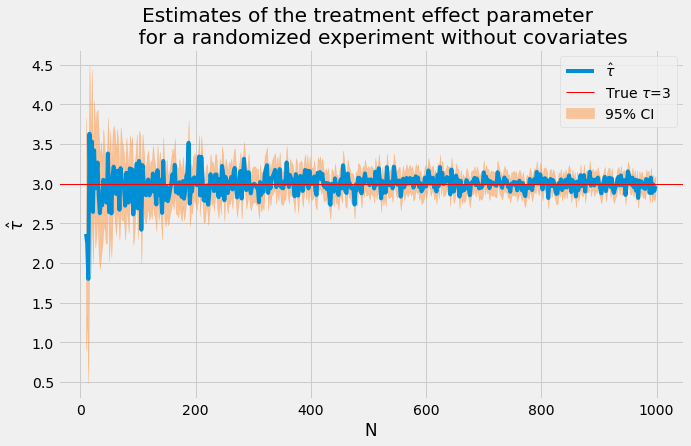

In [4]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without covariates"""
fn_plot_with_ci(nvalues_1,tauhats_1,tau,lb_1,ub_1,caption)

##### For selected N=100 check that parameters and intercepts of OLS Regression

In [5]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb_1 = lb_1 + [tauhat-1.96*se_tauhat]
ub_1 = ub_1 + [tauhat+1.96*se_tauhat]

print (tauhat,se_tauhat)

2.9590505454744633 0.1897993555289448


In [6]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(2.9590505454744633, 0.18979935552894484)

In [7]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     243.1
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           2.74e-28
Time:                        10:40:03   Log-Likelihood:                -135.65
No. Observations:                 100   AIC:                             275.3
Df Residuals:                      98   BIC:                             280.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9591      0.190     15.590      0.000       2.582       3.336
const         -0.0493      0.134     -0.368      0.714      -0.316       0.217
==============================================================================
Omnibus:                        2.491   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                2.270
Skew:                          -0.276   Prob(JB):                        0.321
Kurtosis:                       2.511   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG Graph

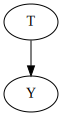

In [8]:
g = Digraph()
g.edge("T", "Y")

g

#### Run R Monte Carlo iterations and compute bias, RMSE and size (for N=100 and N=1000)

In [9]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats+ [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 92.14it/s]


In [10]:
Results1 = []

In [11]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    Results1.append([N,bias,rmse,size])

N=100: bias=-0.002478212931782738, RMSE=0.19663932949447205, size=0.047
N=1000: bias=9.351352883677699e-05, RMSE=0.06268679744432974, size=0.0445


## Case B: Experiments with covariates in the DGP

$y_i=\tau*T_i+X_i+e_i$

#### Data Generation Process

In [12]:
tau = 3
corr = .5
conf = False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_2,tauhats_2,sehats_2,lb_2,ub_2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 166.67it/s]


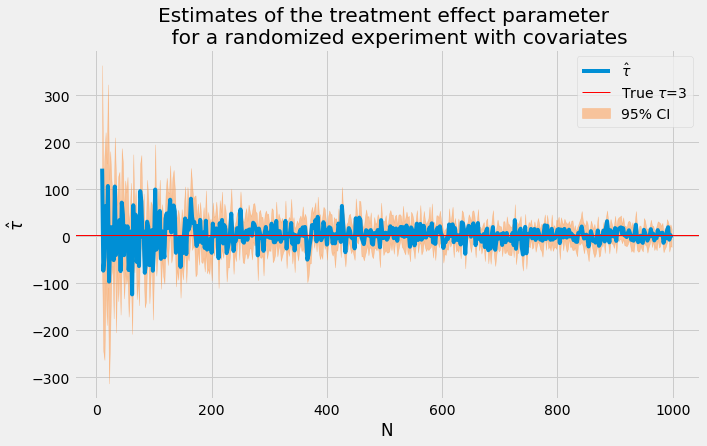

In [13]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with covariates"""
fn_plot_with_ci(nvalues_2,tauhats_2,tau,lb_2,ub_2,caption)

##### For selected N=100 check that parameters and intercepts of OLS Regression

In [14]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,50,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat_2,se_tauhat_2 = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb_2 = lb_2 + [tauhat-1.96*se_tauhat]
ub_2 = ub_2 + [tauhat+1.96*se_tauhat]

print (tauhat,se_tauhat)

2.9944093826885503 0.06376568111840503


In [15]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(-1.8965152386983026, 30.219832854449024)

In [16]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                  0.003938
Date:                Fri, 15 Apr 2022   Prob (F-statistic):              0.950
Time:                        10:40:54   Log-Likelihood:                -642.68
No. Observations:                 100   AIC:                             1289.
Df Residuals:                      98   BIC:                             1295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.8965     30.220     -0.063      0.950     -61.867      58.074
const          1.1566     21.369      0.054      0.957     -41.249      43.562
==============================================================================
Omnibus:                        1.697   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.428   Jarque-Bera (JB):                1.617
Skew:                          -0.305   Prob(JB):                        0.446
Kurtosis:                       2.876   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG Graph

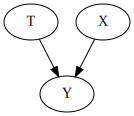

In [17]:
g = Digraph()
g.edge("T", "Y")
g.edge("X","Y")

g

#### Run R Monte Carlo iterations and compute bias, RMSE and size ( for N=100 and N=1000)

In [18]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,50,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat= fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats+ [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 92.18it/s]


In [19]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    Results1.append([N,bias,rmse,size])

N=100: bias=-1.5567867665886788, RMSE=36.60862778232769, size=0.053
N=1000: bias=0.10238091911351818, RMSE=11.558912749535816, size=0.0485


In [20]:
df1 = pd.DataFrame(Results1,columns=['N','Bias','RMSE','Size'],
                  index=['Q1CaseA','','Q1CaseB',''],dtype=float)
df1

,N,Bias,RMSE,Size
Q1CaseA,100.0,-0.002478,0.196639,0.0470
,1000.0,0.000094,0.062687,0.0445
Q1CaseB,100.0,-1.556787,36.608628,0.0530
,1000.0,0.102381,11.558913,0.0485


#### Real Life example

After controlling covariates, the causal relationship between treatment and outcome will become clearer and more accurate.

T:gender(male or female)

Y:wage

X:number of jobs he/she previously has(to depict work experience)

It is like when we are trying to understand the effect of gender on wage, we can control the number of jobs he/she previously has. Because when someone has multiple prior jobs(but it may not be related to gender), it means that he/she has more working experience, which can possibly affect the wage.

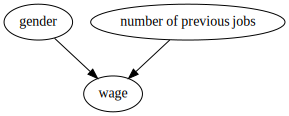

In [21]:
# if we also use DAG to denote the relationship in this example
g = Digraph()
g.edge("gender", "wage")
g.edge("number of previous jobs","wage")

g

# Q2: Experiments with/without controlling confounder

## Case A: Experiments without controlling confounder in the DGP

$y_i=\tau*T_i+e_i$

#### Data Generation Process

In [22]:
tau=4
corr=.5
conf=False
p=100
p0=0
Nrange = range(10,1000,2) # loop over N values
(nvalues_3,tauhats_3,sehats_3,lb_3,ub_3) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 166.31it/s]


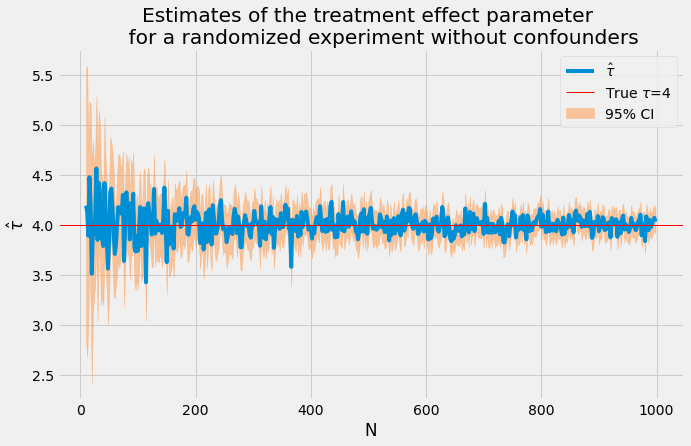

In [23]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues_3,tauhats_3,tau,lb_3,ub_3,caption)

##### For selected N=100 check that parameters and intercepts of OLS Regression

In [24]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat_3,se_tauhat_3 = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb_3 = lb_3 + [tauhat-1.96*se_tauhat]
ub_3 = ub_3 + [tauhat+1.96*se_tauhat]

print (tauhat,se_tauhat)

-1.9896521972777614 8.26718652897963


In [25]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(4.040299796356296, 0.2024788535899836)

In [26]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     398.2
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           2.73e-36
Time:                        10:41:39   Log-Likelihood:                -142.12
No. Observations:                 100   AIC:                             288.2
Df Residuals:                      98   BIC:                             293.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.0403      0.202     19.954      0.000       3.638       4.442
const         -0.2753      0.143     -1.923      0.057      -0.559       0.009
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.445
Skew:                          -0.145   Prob(JB):                        0.801
Kurtosis:                       2.848   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG Graph

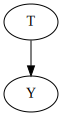

In [27]:
g = Digraph()
g.edge("T","Y")

g

#### Run R Monte Carlo iterations and compute bias, RMSE and size ( For N=100 and N=1000)

In [28]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 190.76it/s]


In [29]:
Results2 = []

In [30]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    Results2.append([N,bias,rmse,size])

N=100: bias=0.0008675702105463921, RMSE=0.20397731928486562, size=0.0575
N=1000: bias=-0.0019450718309092137, RMSE=0.06367389131318237, size=0.055


## Case B: Experiments with controlling confounder in the DGP

$y_i=\tau*T_i+0.6*confmult*C_i+e_i$

$T_i=\alpha*C_i+u_i$

#### Data Generation Process

In [31]:
tau = 4
alpha = 2
corr = .5
conf = True
p = 100
p0 = 0 # number of exogenous covariates used in the DGP
u_i = np.random.normal(0,1,[N,1])
Nrange = range(10,1000,2) # loop over N values
(nvalues_4,tauhats_4,sehats_4,lb_4,ub_4) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 168.32it/s]


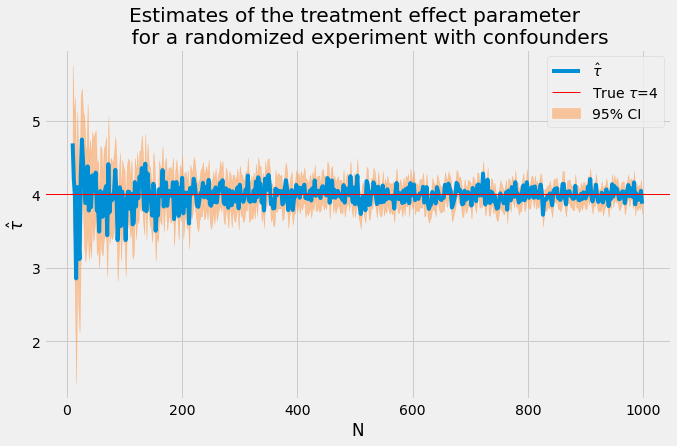

In [32]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with confounders"""
fn_plot_with_ci(nvalues_4,tauhats_4,tau,lb_4,ub_4,caption)

##### For selected N=100 check that parameters and intercepts of OLS Regression

In [33]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb_4 = lb_4 + [tauhat-1.96*se_tauhat]
ub_4 = ub_4 + [tauhat+1.96*se_tauhat]

print (tauhat,se_tauhat)

3.767441550016031 0.2536567151965478


In [34]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(3.7674415500160294, 0.25365671519654776)

In [35]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     220.6
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           7.84e-27
Time:                        10:42:07   Log-Likelihood:                -164.65
No. Observations:                 100   AIC:                             333.3
Df Residuals:                      98   BIC:                             338.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.7674      0.254     14.853      0.000       3.264       4.271
const         -0.0027      0.179     -0.015      0.988      -0.359       0.353
==============================================================================
Omnibus:                        0.070   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.167
Skew:                           0.059   Prob(JB):                        0.920
Kurtosis:                       2.839   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG Graph

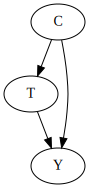

In [36]:
g = Digraph()
g.edge("T","Y")
g.edge("C","T")
g.edge("C","Y")

g

#### Run R Monte Carlo iterations and compute bias, RMSE and size ( For N=100 and N=1000)

In [37]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 91.76it/s]


In [38]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    Results2.append([N,bias,rmse,size])

N=100: bias=0.0010326038893640535, RMSE=0.2388866738594691, size=0.058
N=1000: bias=0.00016079166272094024, RMSE=0.07613696869528291, size=0.0585


In [39]:
df2 = pd.DataFrame(Results2,columns=['N','Bias','RMSE','Size'],
                  index=['Q2CaseA','','Q2CaseB',''],dtype=float)

df2

,N,Bias,RMSE,Size
Q2CaseA,100.0,0.000868,0.203977,0.0575
,1000.0,-0.001945,0.063674,0.0550
Q2CaseB,100.0,0.001033,0.238887,0.0580
,1000.0,0.000161,0.076137,0.0585


#### Real Life example

After controlling confounders, the causal relationship between treatment and outcome will become clearer and more accurate.

For example,

T:smoking

Y:respiratory disease

C:age

For example, when we are trying to understand how whether one has smoking habit can affect the possibility of respiratory disease, we may want to control confounder age. Teengers and children have limited access to cigaratees because knowingly selling cigaratees to them is illegal. So, when we controll age, we are looking at the causal relationship between smoking and respiratory disease under different subpopulation, which gives a clearer picture.

another example would be

T:marketing ads of boat company online

Y:click-through rate

C:regions (whether the region is near waters)

when we are trying to understand how whether posting ads online can affect the click through rate for boat company, we may want to control confounder regions (whether the region is close to waters). If a person lives near waters,he is more likely to search for boat ads online and click through. So, when we controll region, we are looking at the causal relationship between ads and click through rate under different subpopulation, which gives a clearer picture.


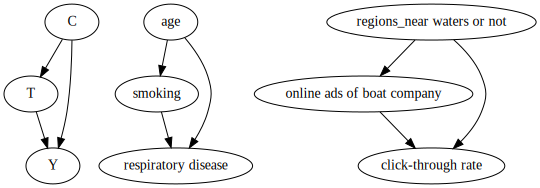

In [40]:
# if we also use DAG to denote the relationships in this example
g.edge("smoking","respiratory disease")
g.edge("age","respiratory disease")
g.edge("age","smoking")

g.edge("online ads of boat company","click-through rate")
g.edge("regions_near waters or not","online ads of boat company")
g.edge("regions_near waters or not","click-through rate")

g

# Q3: Experiments with/without controlling selection bias

## Case A: Experiments without controlling selection bias in the DGP

$y_i=\tau*T_i+e_i$

#### Data Generation Process

In [28]:
tau = 5
corr = .5
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_5,tauhats_5,sehats_5,lb_5,ub_5) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 168.62it/s]


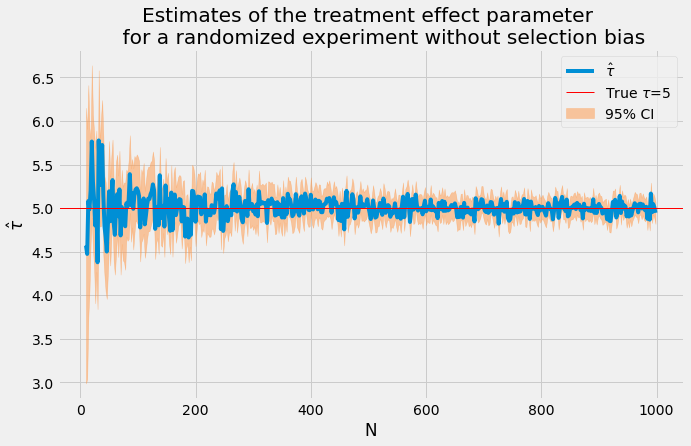

In [29]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without selection bias"""
fn_plot_with_ci(nvalues_5,tauhats_5,tau,lb_5,ub_5,caption)

##### For selected N=100 check that parameters and intercepts of OLS Regression

In [30]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb_5 = lb_5 + [tauhat-1.96*se_tauhat]
ub_5 = ub_5 + [tauhat+1.96*se_tauhat]

print (tauhat,se_tauhat)

5.143823265358279 0.21061280060312484


In [31]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(5.143823265358277, 0.21061280060312484)

In [32]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     596.5
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           1.85e-43
Time:                        11:59:56   Log-Likelihood:                -146.05
No. Observations:                 100   AIC:                             296.1
Df Residuals:                      98   BIC:                             301.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.1438      0.211     24.423      0.000       4.726       5.562
const          0.2042      0.149      1.371      0.174      -0.091       0.500
==============================================================================
Omnibus:                        0.172   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.917   Jarque-Bera (JB):                0.296
Skew:                          -0.088   Prob(JB):                        0.862
Kurtosis:                       2.800   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG graph

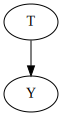

In [33]:
g = Digraph()
g.edge("T", "Y")

g

#### Run R Monte Carlo iterations and compute bias, RMSE and size ( for N=100 and N=1000)

In [34]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 92.07it/s]


In [35]:
Results3 = []

In [36]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    Results3.append([N,bias,rmse,size])

N=100: bias=0.001197160209489963, RMSE=0.19941739936025749, size=0.051
N=1000: bias=0.0014022213933317213, RMSE=0.06250616045482155, size=0.0485


## Case B: Experiments with controlling selection bias in the DGP

$y_i=\tau*T_i+e_i$

Z is a outcome both for Y and T, use np.ramdom.normal() to draw Z accordingly.

#### Data Generation Process

In [37]:
tau = 5
gamma = 3
sigma = 5
corr = .5
conf = False
n = 50
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_6,tauhats_6,sehats_6,lb_6,ub_6) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)
e_i = np.random.normal(0,1,[n,1])
Y = tau*nvalues_6+e_i
Z = np.random.normal(5+np.mean(nvalues_6)*np.mean(Y),5,n)

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 168.77it/s]


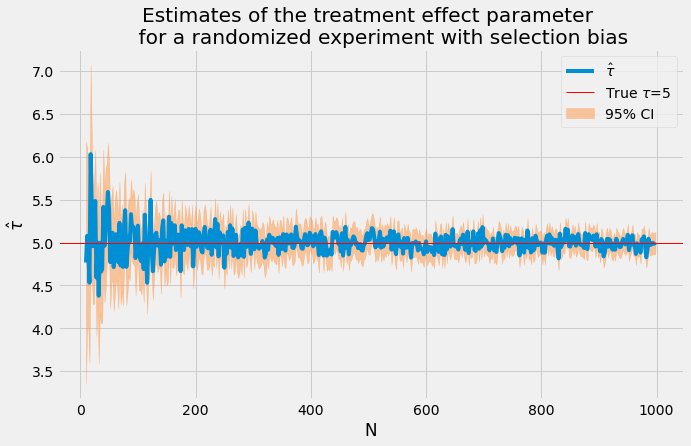

In [39]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with selection bias"""
fn_plot_with_ci(nvalues_6,tauhats_6,tau,lb_6,ub_6,caption)

##### For selected N=100 check that parameters and intercepts of OLS Regression

In [40]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb_6 = lb_6 + [tauhat-1.96*se_tauhat]
ub_6 = ub_6 + [tauhat+1.96*se_tauhat]

print (tauhat,se_tauhat)

4.867283665195489 0.19665023894136177


In [41]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(4.867283665195489, 0.19665023894136174)

In [42]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     612.6
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           5.98e-44
Time:                        12:00:39   Log-Likelihood:                -139.19
No. Observations:                 100   AIC:                             282.4
Df Residuals:                      98   BIC:                             287.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.8673      0.197     24.751      0.000       4.477       5.258
const          0.2946      0.139      2.119      0.037       0.019       0.571
==============================================================================
Omnibus:                        1.129   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.569   Jarque-Bera (JB):                0.628
Skew:                           0.048   Prob(JB):                        0.731
Kurtosis:                       3.376   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG graph

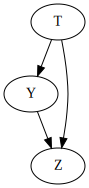

In [43]:
g = Digraph()
g.edge("T","Y")
g.edge("T","Z")
g.edge("Y","Z")

g

#### Run R Monte Carlo iterations and compute bias, RMSE and size (for N=100 and N=1000)

In [44]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 90.18it/s]


In [45]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    Results3.append([N,bias,rmse,size])

N=100: bias=0.004412119646348063, RMSE=0.2015171502358958, size=0.0515
N=1000: bias=0.0012207890732437324, RMSE=0.06469577078419136, size=0.0595


In [46]:
df3 = pd.DataFrame(Results3,columns=['N','Bias','RMSE','Size'],
                  index=['Q3CaseA','','Q3CaseB',''],dtype=float)

df3

,N,Bias,RMSE,Size
Q3CaseA,100.0,0.001197,0.199417,0.0510
,1000.0,0.001402,0.062506,0.0485
Q3CaseB,100.0,0.004412,0.201517,0.0515
,1000.0,0.001221,0.064696,0.0595


#### Real Life example

In this case, if selection bias emergers, the causal relationship between treatment and outcome will become weaker and unclearer. This is because we are overly controlling for variables (Z) that are consequences of both T (treatment) and Y (outcome).

For example 

T : fliers of a protein powder brand

Y : brand awareness of a protein powder 

Z : Posting survey sheet outside a gym

For example, when we want to see if fliers of a certain protein power brand can affect people's brand awareness of a protein powder, we need to avoid controlling for location to do the survey (gym). This is because people who work out at a gym tend to buy protein power, so people at the gym might self-select themsevles into the survey and cause unwanted bias caused by a biased sample.

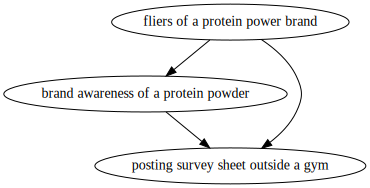

In [59]:
# if we also use DAG to denote the relationships in this example
g = Digraph()
g.edge("fliers of a protein power brand","brand awareness of a protein powder")
g.edge("fliers of a protein power brand","posting survey sheet outside a gym")
g.edge("brand awareness of a protein powder","posting survey sheet outside a gym")

g